In [17]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
np.random.seed(123)

%pylab inline

#!wget http://stanford.edu/~boyd/cvxbook/cvxbook_additional_exercises/portf_weight_rebalance_data.py
#!cat portf_weight_rebalance_data.py

Populating the interactive namespace from numpy and matplotlib


In [18]:
# data 
import numpy as np
import cvxpy as cvx
T = 100
n = 5
gamma = 8.0
threshold = 0.001

Sigma = np.array([[1.512e-02,  1.249e-03,  2.762e-04, -5.333e-03, -7.938e-04],
                 [ 1.249e-03,  1.030e-02,  6.740e-05, -1.301e-03, -1.937e-04],
                 [ 2.762e-04,  6.740e-05,  1.001e-02, -2.877e-04, -4.283e-05],
                 [-5.333e-03, -1.301e-03, -2.877e-04,  1.556e-02,  8.271e-04],
                 [-7.938e-04, -1.937e-04, -4.283e-05,  8.271e-04,  1.012e-02]])

mu = np.array([ 1.02 , 1.028, 1.01 , 1.034, 1.017])
kappa_1 = np.matrix([ 0.002, 0.002, 0.002, 0.002, 0.002])
kappa_2 = np.matrix([ 0.004, 0.004, 0.004, 0.004, 0.004])

## generate a vector r of market returns
generateReturns = lambda: np.random.multivariate_normal(mu,Sigma)

In [19]:
def opt_port(mu, Sigma, gamma, trans_costs=False, 
             kappa=None, wt=None):
    """ Compuptes single period optimal portfolio
    """
    
    # initialize variable to optimize
    w = cvx.Variable(n)
    
    # coerce wt matrix to be a column vector
    wt = np.reshape(np.matrix(wt), (-1, 1))
    
    # objective function to maximize
    obj_func = w.T * mu - gamma / 2 * cvx.quad_form(w, Sigma)
    
    if trans_costs:
        obj_func -= kappa * cvx.abs(w - wt)
       
    # define constraints
    constraints = [cvx.sum_entries(w) == 1]
    
    # define convex optimization problem
    obj = cvx.Maximize(obj_func)
    prob = cvx.Problem(obj, constraints)
    
    # solve convex optimization problem
    prob.solve(solver=cvx.ECOS)
    
    return w.value

In [20]:
def run_multi_period_opt(mu, Sigma, gamma, kappa):
    """ Simulates multi-period portfolio optimization
    """
    w_star = opt_port(mu, Sigma, gamma).T

    # pre-trade weights
    wt = np.zeros((T, n))

    # post-trade weights
    ws = wt.copy()

    # trade weights
    us = ws.copy()

    # start at optimal
    ws[0, :] = w_star.copy()

    # multi-period rebalancing
    for t in xrange(1, T):

        # grow weights due to simulated market returns
        wt[t, :] = grow_weights(ws[t-1, :]).T

        # construct optimal portfolio 
        ws[t, :] = opt_port(mu, Sigma, gamma, 
                               trans_costs=True, kappa=kappa, wt=wt[t, :]).T

        # trades
        us[t, :] = ws[t, :] - wt[t, :]
        
    return ws, us, np.array(w_star)[0], wt

In [21]:
def grow_weights(wt):
    # grows weights by simulated market returns
    wt = np.reshape(np.matrix(wt), (-1, 1))
    rt = generateReturns()
    return (np.diag(rt) * wt) / (rt * wt)

In [22]:
def plot_weights(ws, us, w_star):
    """ Plotting code
    Provide three objects:
        - ws: np.array of size T x n,
              the post-trade weights w_t_tilde;
        - us: np.array of size T x n, 
              the trades at each period: w_t_tilde - w_t;
        - w_star: np.array of size n,
              the "target" solution w_star.
    """
    colors = ['b','r','g','c','m']
    plt.figure(figsize=(13,5))
    for j in range(n):
        plt.plot(range(T), ws[:,j], colors[j])
        plt.plot(range(T), [w_star[j]]*T,  colors[j]+'--')
        non_zero_trades = abs(us[:,j]) > threshold
        plt.plot(np.arange(T)[non_zero_trades],
            ws[non_zero_trades, j], colors[j]+'o')
    plt.ylabel('post-trade weights')
    plt.xlabel('period $t$')   

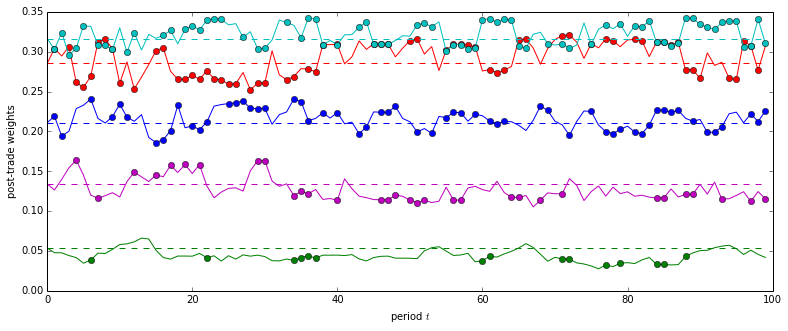

In [23]:
ws, us, w_star, wt = run_multi_period_opt(mu, Sigma, gamma, kappa=kappa_1)
plot_weights(ws, us, w_star)

In [24]:
def frac_tiny_trades(us):
    return 1.0 * np.sum(np.max(us, 1) <= 1e-3) / len(us)

In [25]:
print "tiny trades ", frac_tiny_trades(us)

tiny trades  0.16


In [26]:
def frac_no_trade_cond(wt, gamma, Sigma, kappa, w_star):
    no_trad_cond = (gamma * np.abs(np.dot(wt - w_star, Sigma)) <= kappa).all(axis=1)
    return 1.0 * np.sum(no_trad_cond) / len(no_trad_cond)

In [27]:
frac_no_trade = frac_no_trade_cond(wt, gamma, Sigma, kappa_1, w_star)
print "frac periods no trade cond",  frac_no_trade

frac periods no trade cond 0.06


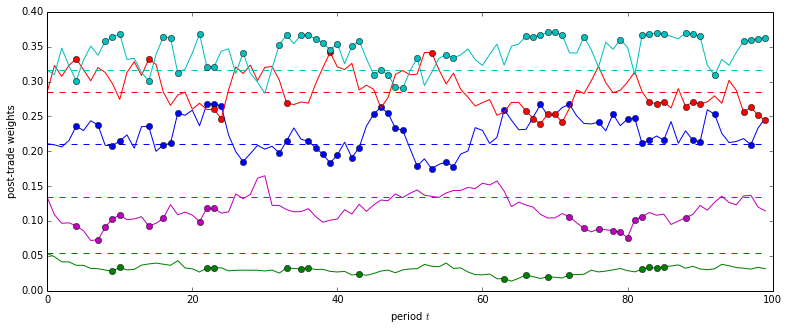

In [29]:
ws, us, w_star, wt = run_multi_period_opt(mu, Sigma, gamma, kappa=kappa_2)
plot_weights(ws, us, w_star)

In [30]:
# we see that for high transaction costs, 36% of periods negligible trades (too expensive!)
print "tiny trades ", frac_tiny_trades(us)

tiny trades  0.41


In [31]:
# with high transaction costs, the deviation of wt from
# the target portfolio is infrequently less than the cost of tradding
frac_no_trade = frac_no_trade_cond(wt, gamma, Sigma, kappa_1, w_star)
print "frac periods no trade cond",  frac_no_trade

frac periods no trade cond 0.03
